# Sparse Sheaf Signal Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from vdm import VDM
import cvxpy as cp
from sklearn.linear_model import OrthogonalMatchingPursuit
from wavelet import Wavelet
from builder import CochainSample # builder.py file provided by project supervisor
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict
from utils import fibonacci_sphere, geodetic_to_ecef, project_to_tangent
from tsp import TSP
import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

# Synthetic Datasets

## Random Point Cloud in a Cube

In [ ]:
# Generate a cube in R^3 with uniformly random points
N = 300 # number of points in the cloud
cube_point_cloud = np.random.uniform(-0.5,0.5,N*3).reshape((N, 3)) # points
# Create a topological signal processing object
cube = TSP(cube_point_cloud, eps=0.1, eps_pca=0.05, k=30, gamma=0.95)

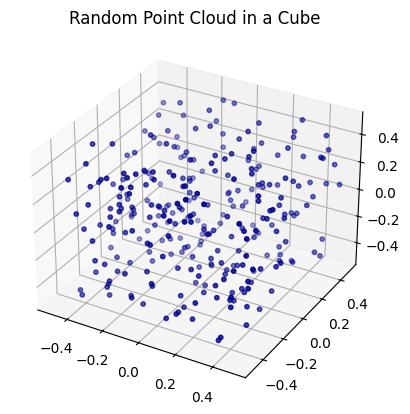

In [3]:
cube.plot_points('Random Point Cloud in a Cube')

In [4]:
# Print manifold dimension
print(f"Estimated dimension of the manifold: {cube.estimate_dim()}")

Estimated dimension of the manifold: 2


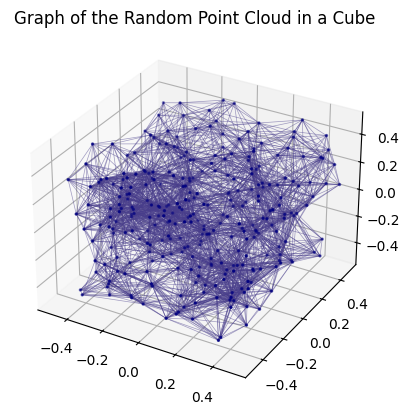

In [5]:
cube.plot_graph("Graph of the Random Point Cloud in a Cube")

#### Build the Laplacians

In [7]:
L_conn_cube = cube.connection_laplacian() # Connection Laplacian
L_trivial_cube = cube.trivial_laplacian() # Trivial Laplacian
L_trivial_norm_cube = cube.trivial_laplacian_norm() # Normalized Trivial Laplacian
L_sheaf_cube = cube.sheaf_laplacian() # Sheaf Laplacian

### Generate Signals

#### Steps for Building the signals

1. We already have the geometry: $x \in \mathbb{R}^{N \times 3}$ and $O[i] \in \mathbb{R}^{3 \times 2}$

2. Generating a Kraichnan Field, computing:

$$
\mathbf{U}(x) = \bar{U} \mathbf{e}_1 - \sqrt{\frac{\sigma^2}{n}} \sum_{i=1}^n \mathbf{p}(\mathbf{k_i}) [Z_{1,i} \cos(\langle \mathbf{k_i}, \mathbf{x} \rangle) + \sin(\langle \mathbf{k_i}, \mathbf{x} \rangle)]
$$

with the projector

$$
\mathbf{p}(\mathbf{k_i}) = \mathbf{e_1} - \frac{\mathbf{k_i} k_1}{\mathbf{k}^2}
$$

and the incompressibility property $ \nabla \cdot \mathbf{U}=0$.

3. Sampling the field on the points, finding $u_i = U(x_i) \in \mathbb{R}^3$. The result is a matrix U in $R^{3 \times N}$ where $N$ is the number of nodes.

4. Projecting the points onto the tangent spaces: $O_i^T u_i \in \mathbb{R}^2$ for every point. Together, they form a matrix in $\mathbb{R}^{2N}$.

5. We repeat points 2-4 $M$ times, ending up with a matrix $X \in \mathbb{R}^{2N \times M}$.

6. Computing the covariance matrix $\Sigma \in \mathbb{R}^{2N \times 2N}$

In [8]:
# Generate the kraichnan signals
X_cube, cov_cube, X_GT_cube = cube.generate_kraichnan_signals()

### Dictionaries

In [9]:
# Build the dictionaries
dictionaries_cube = cube.make_dictionaries()

### Sparse Signal Processing

We want to find sparse representations of the signals using the laplacian dictionaries.

To evaluate the quality of the signal representation, two measures are taken into consideration:
- Number of non-zero coefficients (or above a tolerance)
- Approximation error

In [10]:
# Find the sparse signals
sparse_signals_cube = cube.sparsify_signals(X_cube[:,:50])

100%|██████████| 50/50 [05:15<00:00,  6.31s/it]


In [11]:
# Compute the sparsity and the NMSE
sparsity_cube = cube.compute_sparsity(sparse_signals_cube)
nmse_cube = cube.compute_NMSE(X_GT_cube[:,:50], sparse_signals_cube)

In [12]:
# Print results
print(f"Sparsity (connection laplacian): {sparsity_cube['Connection'][0]} %")
print(f"Sparsity (trivial laplacian): {sparsity_cube['Trivial'][0]} %")
print(f"Sparsity (normalized trivial laplacian): {sparsity_cube['Trivial Normalized'][0]} %")
print(f"Sparsity (sheaf laplacian): {sparsity_cube['Sheaf'][0]} %")
print(f"NMSE (connection laplacian): {nmse_cube['Connection'][0]}")
print(f"NMSE (trivial laplacian): {nmse_cube['Trivial'][0]}")
print(f"NMSE (normalized trivial laplacian): {nmse_cube['Trivial Normalized'][0]}")
print(f"NMSE (sheaf laplacian): {nmse_cube['Sheaf'][0]}")

Sparsity (connection laplacian): 10.0 %
Sparsity (trivial laplacian): 10.0 %
Sparsity (normalized trivial laplacian): 10.0 %
Sparsity (sheaf laplacian): 10.0 %
NMSE (connection laplacian): 1.49436466693796
NMSE (trivial laplacian): 0.23620705925246036
NMSE (normalized trivial laplacian): 0.24334454619389934
NMSE (sheaf laplacian): 0.955641151575878


In [13]:
print(f"Average NMSE (Connection Laplacian): {np.mean(nmse_cube['Connection'])}")
print(f"Average NMSE (Trivial Laplacian): {np.mean(nmse_cube['Trivial'])}")
print(f"Average NMSE (Normalized Trivial Laplacian): {np.mean(nmse_cube['Trivial Normalized'])}")
print(f"Average NMSE (Sheaf Laplacian): {np.mean(nmse_cube['Sheaf'])}")

Average NMSE (Connection Laplacian): 0.9026147196830857
Average NMSE (Trivial Laplacian): 0.24484783671734509
Average NMSE (Normalized Trivial Laplacian): 0.24862968229660104
Average NMSE (Sheaf Laplacian): 0.5221328653947467


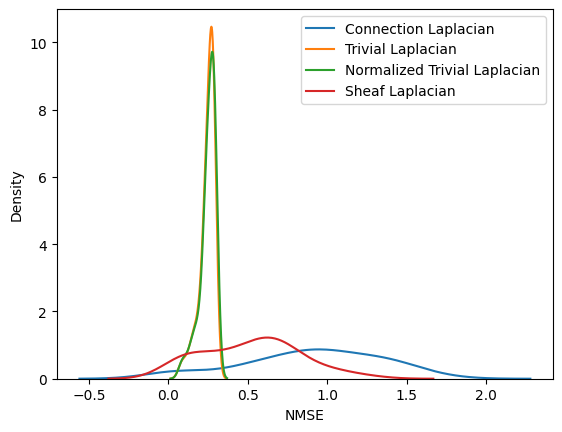

In [14]:
cube.plot_nmse(nmse_cube)

#### Experiment

In [39]:
# Initialize result dictionaries
sparsity_results = {}
nmse_results = {}

# Hyperparameters
SEED = 42
eps_ = [0.15, 0.15, 0.1, 0.1, 0.1] # eps for the graph
eps_pca_ = [0.1, 0.1, 0.05, 0.05, 0.05] # eps for the local PCA
k_ = [20, 30, 30, 30, 30] # knn
gamma_ = [0.98, 0.97, 0.95, 0.95, 0.95] # information variability threshold
N_ = [100, 250, 500, 750, 1000] # number of samples

for i, N in enumerate(N_):
    # Generate data
    np.random.seed(SEED)
    cube_point_cloud = np.random.uniform(-0.5,0.5,N*3).reshape((N, 3))
    # Create TSP object
    cube = TSP(cube_point_cloud, eps=eps_[i], eps_pca=eps_pca_[i], k=k_[i], gamma=gamma_[i])
    # Create dictionaries
    dictionaries_cube = cube.make_dictionaries()
    # Generate signals
    X_cube, cov_cube, X_GT_cube = cube.generate_kraichnan_signals()
    # Sparsify signals
    sparse_signals_cube = cube.sparsify_signals(X_cube[:,:50])
    # Compute sparsity
    sparsity_cube = cube.compute_sparsity(sparse_signals_cube)
    # Compute NMSE
    nmse_cube = cube.compute_NMSE(X_GT_cube[:,:50], sparse_signals_cube)
    # Add sparsity and NMSE to the dictionaries
    sparsity_results[N] = sparsity_cube
    nmse_results[N] = nmse_cube

100%|██████████| 50/50 [2:23:55<00:00, 172.71s/it]  


In [40]:
np.save('cube_sparsity_results.npy', sparsity_results)
np.save('cube_nmse_results.npy', nmse_results)

In [75]:
for N in N_:
    print(f"{N} Samples: Mean Sparsity (connection laplacian): {np.mean(sparsity_results[N]['Connection'])} %")
    print(f"{N} Samples: Mean Sparsity (trivial laplacian): {np.mean(sparsity_results[N]['Trivial'])} %")
    print(f"{N} Samples: Mean Sparsity (normalized trivial laplacian): {np.mean(sparsity_results[N]['Trivial Normalized'])} %")
    print(f"{N} Samples: Mean Sparsity (sheaf laplacian): {np.mean(sparsity_results[N]['Sheaf'])} %")
    print(f"{N} Samples: Mean NMSE (connection laplacian): {np.mean(nmse_results[N]['Connection'])}")
    print(f"{N} Samples: Mean NMSE (trivial laplacian): {np.mean(nmse_results[N]['Trivial'])}")
    print(f"{N} Samples: Mean NMSE (normalized trivial laplacian): {np.mean(nmse_results[N]['Trivial Normalized'])}")
    print(f"{N} Samples: Mean NMSE (sheaf laplacian): {np.mean(nmse_results[N]['Sheaf'])}")
    print("\n")

100 Samples: Mean Sparsity (connection laplacian): 10.0 %
100 Samples: Mean Sparsity (trivial laplacian): 10.0 %
100 Samples: Mean Sparsity (normalized trivial laplacian): 10.0 %
100 Samples: Mean Sparsity (sheaf laplacian): 10.0 %
100 Samples: Mean NMSE (connection laplacian): 0.9977178465670261
100 Samples: Mean NMSE (trivial laplacian): 0.2587795997705279
100 Samples: Mean NMSE (normalized trivial laplacian): 0.2578149922861653
100 Samples: Mean NMSE (sheaf laplacian): 0.7811748860136488


250 Samples: Mean Sparsity (connection laplacian): 10.0 %
250 Samples: Mean Sparsity (trivial laplacian): 10.0 %
250 Samples: Mean Sparsity (normalized trivial laplacian): 10.0 %
250 Samples: Mean Sparsity (sheaf laplacian): 10.0 %
250 Samples: Mean NMSE (connection laplacian): 1.0086638353617254
250 Samples: Mean NMSE (trivial laplacian): 0.31702443064245917
250 Samples: Mean NMSE (normalized trivial laplacian): 0.30936410894936134
250 Samples: Mean NMSE (sheaf laplacian): 0.1739118064398302


50

In [54]:
def plot_nmse_distribution(nmse,title='NMSE Distribution'):
    sns.kdeplot(nmse['Connection'], label='Connection Laplacian')
    sns.kdeplot(nmse['Trivial'], label='Trivial Laplacian')
    sns.kdeplot(nmse['Trivial Normalized'], label='Normalized Trivial Laplacian')
    sns.kdeplot(nmse['Sheaf'], label='Sheaf Laplacian')
    plt.xlabel('NMSE')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()

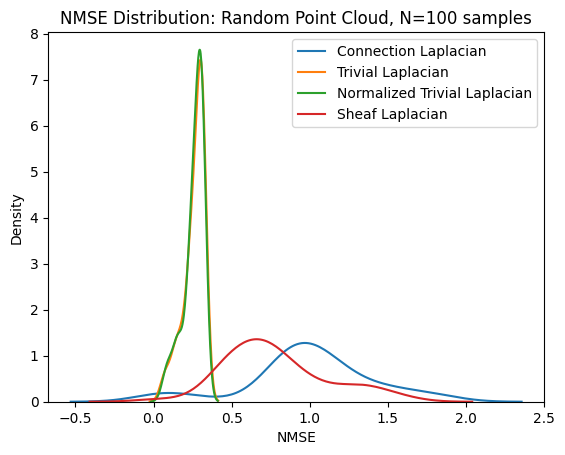

In [56]:
plot_nmse_distribution(nmse_results[100],'NMSE Distribution: Random Point Cloud, N=100 samples')

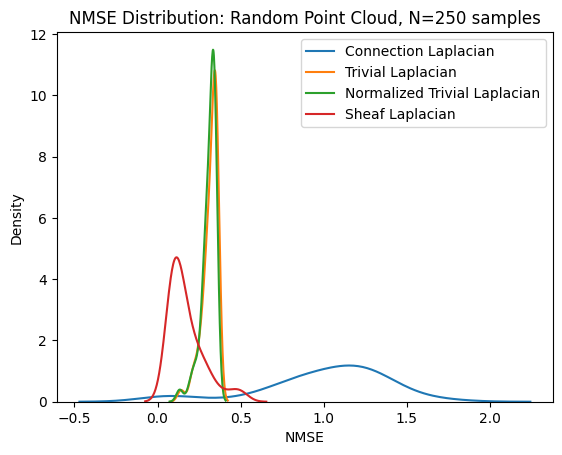

In [59]:
plot_nmse_distribution(nmse_results[250],'NMSE Distribution: Random Point Cloud, N=250 samples')

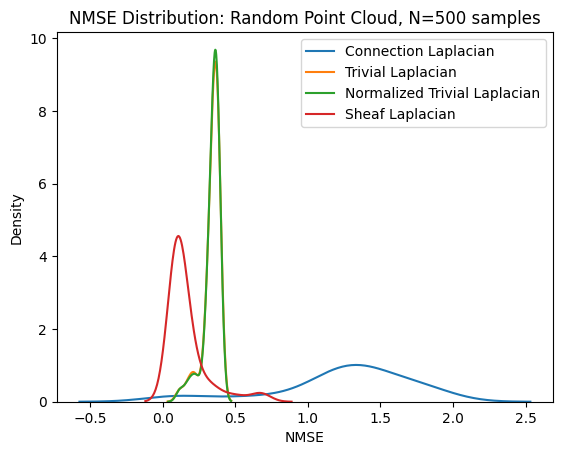

In [60]:
plot_nmse_distribution(nmse_results[500],'NMSE Distribution: Random Point Cloud, N=500 samples')

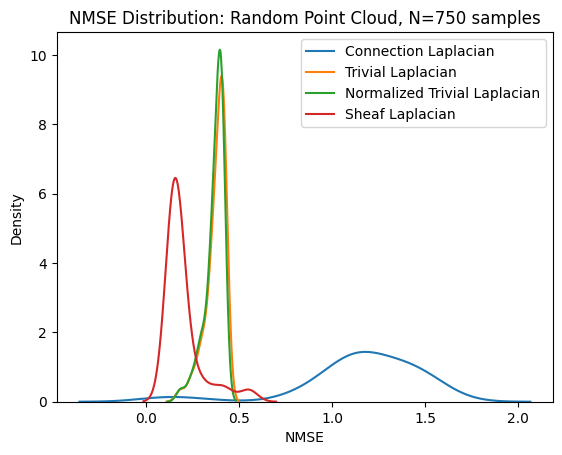

In [61]:
plot_nmse_distribution(nmse_results[750],'NMSE Distribution: Random Point Cloud, N=750 samples')

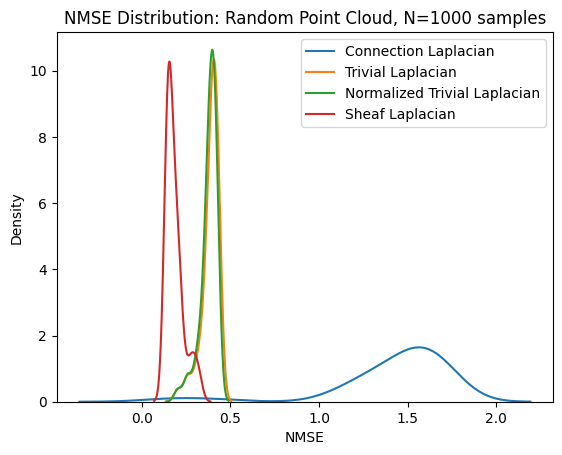

In [62]:
plot_nmse_distribution(nmse_results[1000],'NMSE Distribution: Random Point Cloud, N=1000 samples')

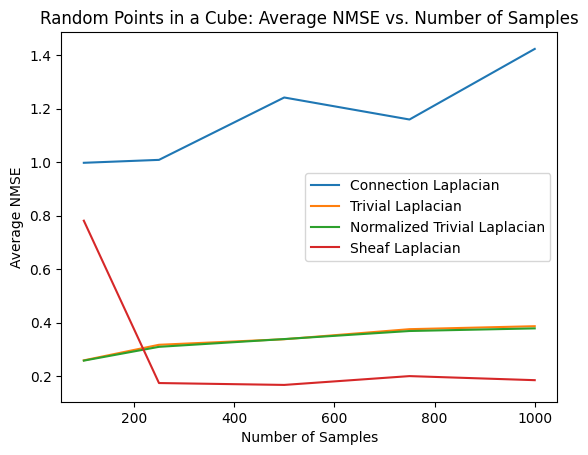

In [73]:
# Compute average NMSEs
cube_avg_nmse_conn = []
cube_avg_nmse_trivial = []
cube_avg_nmse_trivial_norm = []
cube_avg_nmse_sheaf = []

for N in N_:
    cube_avg_nmse_conn.append(np.mean(nmse_results[N]['Connection']))
    cube_avg_nmse_trivial.append(np.mean(nmse_results[N]['Trivial']))
    cube_avg_nmse_trivial_norm.append(np.mean(nmse_results[N]['Trivial Normalized']))
    cube_avg_nmse_sheaf.append(np.mean(nmse_results[N]['Sheaf']))

# Plot average NMSEs vs. number of samples
plt.plot(N_, cube_avg_nmse_conn, label='Connection Laplacian')
plt.plot(N_, cube_avg_nmse_trivial, label='Trivial Laplacian')
plt.plot(N_, cube_avg_nmse_trivial_norm, label='Normalized Trivial Laplacian')
plt.plot(N_, cube_avg_nmse_sheaf, label='Sheaf Laplacian')
plt.xlabel('Number of Samples')
plt.ylabel('Average NMSE')
plt.title('Random Points in a Cube: Average NMSE vs. Number of Samples')
plt.legend()
plt.show()

## Fibonacci Sphere

In [15]:
N = 300 # number of points
sphere_points = fibonacci_sphere(N) # Generate the Fibonacci sphere
# Create a topological signal processing object
sphere = TSP(sphere_points, eps=0.1, eps_pca=0.05, k=30, gamma=0.95)

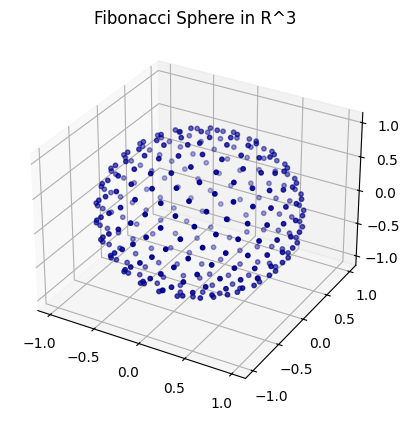

In [16]:
sphere.plot_points('Fibonacci Sphere in R^3')

In [17]:
# Print manifold dimension
print(f"Estimated dimension of the manifold: {sphere.estimate_dim()}")

Estimated dimension of the manifold: 2


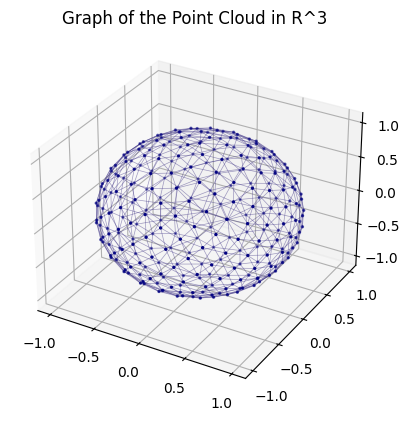

In [18]:
sphere.plot_graph()

#### Build the Laplacians

In [19]:
L_conn_sphere = sphere.connection_laplacian() # Connection Laplacian
L_trivial_sphere = sphere.trivial_laplacian() # Trivial Laplacian
L_trivial_norm_sphere = sphere.trivial_laplacian_norm() # Normalized Trivial Laplacian
L_sheaf_sphere = sphere.sheaf_laplacian() # Sheaf Laplacian

#### Generate Signals

In [20]:
X_sphere, cov_sphere, X_GT_sphere = sphere.generate_kraichnan_signals()

#### Dictionaries

In [21]:
dictionaries = sphere.make_dictionaries(scales=[2**(j-2) for j in range(5)])

### Sparse Signal Processing

In [22]:
sparse_signals_sphere = sphere.sparsify_signals(X_sphere[:,:50])

100%|██████████| 50/50 [02:32<00:00,  3.05s/it]


In [23]:
sparsity_sphere = sphere.compute_sparsity(sparse_signals_sphere)
nmse_sphere = sphere.compute_NMSE(X_GT_sphere[:,:50], sparse_signals_sphere)

In [24]:
print(f"Average NMSE (Connection Laplacian): {np.mean(nmse_sphere['Connection'])}")
print(f"Average NMSE (Trivial Laplacian): {np.mean(nmse_sphere['Trivial'])}")
print(f"Average NMSE (Normalized Trivial Laplacian): {np.mean(nmse_sphere['Trivial Normalized'])}")
print(f"Average NMSE (Sheaf Laplacian): {np.mean(nmse_sphere['Sheaf'])}")

Average NMSE (Connection Laplacian): 0.4434800492852306
Average NMSE (Trivial Laplacian): 0.08493354769538605
Average NMSE (Normalized Trivial Laplacian): 0.07810168394525924
Average NMSE (Sheaf Laplacian): 0.25724484775386924


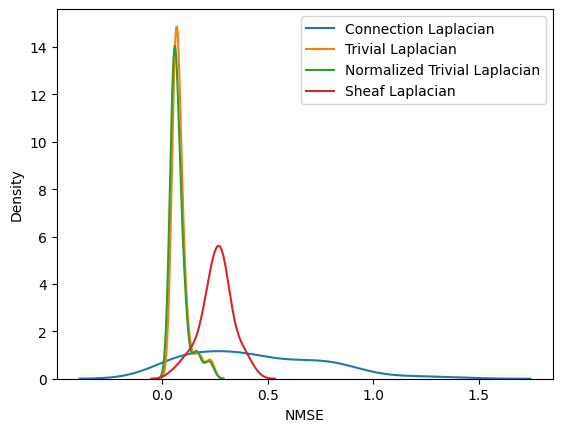

In [25]:
sphere.plot_nmse(nmse_sphere)

In [43]:
# Initialize result dictionaries
sphere_sparsity_results = {}
sphere_nmse_results = {}

# Hyperparameters
SEED = 42
eps_ = [0.15, 0.15, 0.1, 0.1, 0.1] # eps for the graph
eps_pca_ = [0.13, 0.13, 0.05, 0.05, 0.05] # eps for the local PCA
k_ = [20, 30, 30, 30, 30] # knn
gamma_ = [0.98, 0.97, 0.95, 0.95, 0.95] # information variability threshold
N_ = [100, 250, 500, 750, 1000] # number of samples

for i, N in enumerate(N_):
    # Generate data
    np.random.seed(SEED)
    sphere_points = fibonacci_sphere(N)
    # Create TSP object
    sphere = TSP(sphere_points, eps=eps_[i], eps_pca=eps_pca_[i], k=k_[i], gamma=gamma_[i])
    # Create dictionaries
    dictionaries_sphere = sphere.make_dictionaries()
    # Generate signals
    X_sphere, cov_sphere, X_GT_sphere = sphere.generate_kraichnan_signals()
    # Sparsify signals
    sparse_signals_sphere = sphere.sparsify_signals(X_sphere[:,:50])
    # Compute sparsity
    sparsity_sphere = sphere.compute_sparsity(sparse_signals_sphere)
    # Compute NMSE
    nmse_sphere = sphere.compute_NMSE(X_GT_sphere[:,:50], sparse_signals_sphere)
    # Add sparsity and NMSE to the dictionaries
    sphere_sparsity_results[N] = sparsity_sphere
    sphere_nmse_results[N] = nmse_sphere

100%|██████████| 50/50 [2:23:32<00:00, 172.25s/it]  


In [44]:
np.save('sphere_nmse_results.npy', sphere_nmse_results)
np.save('sphere_sparsity_results.npy', sphere_sparsity_results)

In [76]:
for N in N_:
    print(f"{N} Samples: Mean Sparsity (connection laplacian): {np.mean(sphere_sparsity_results[N]['Connection'])} %")
    print(f"{N} Samples: Mean Sparsity (trivial laplacian): {np.mean(sphere_sparsity_results[N]['Trivial'])} %")
    print(f"{N} Samples: Mean Sparsity (normalized trivial laplacian): {np.mean(sphere_sparsity_results[N]['Trivial Normalized'])} %")
    print(f"{N} Samples: Mean Sparsity (sheaf laplacian): {np.mean(sphere_sparsity_results[N]['Sheaf'])} %")
    print(f"{N} Samples: Mean NMSE (connection laplacian): {np.mean(sphere_nmse_results[N]['Connection'])}")
    print(f"{N} Samples: Mean NMSE (trivial laplacian): {np.mean(sphere_nmse_results[N]['Trivial'])}")
    print(f"{N} Samples: Mean NMSE (normalized trivial laplacian): {np.mean(sphere_nmse_results[N]['Trivial Normalized'])}")
    print(f"{N} Samples: Mean NMSE (sheaf laplacian): {np.mean(sphere_nmse_results[N]['Sheaf'])}")
    print("\n")

100 Samples: Mean Sparsity (connection laplacian): 10.0 %
100 Samples: Mean Sparsity (trivial laplacian): 10.0 %
100 Samples: Mean Sparsity (normalized trivial laplacian): 10.0 %
100 Samples: Mean Sparsity (sheaf laplacian): 10.0 %
100 Samples: Mean NMSE (connection laplacian): 0.2107777581549539
100 Samples: Mean NMSE (trivial laplacian): 0.17053331490833085
100 Samples: Mean NMSE (normalized trivial laplacian): 0.17432110995667635
100 Samples: Mean NMSE (sheaf laplacian): 0.41167968215369727


250 Samples: Mean Sparsity (connection laplacian): 10.0 %
250 Samples: Mean Sparsity (trivial laplacian): 10.0 %
250 Samples: Mean Sparsity (normalized trivial laplacian): 10.0 %
250 Samples: Mean Sparsity (sheaf laplacian): 10.0 %
250 Samples: Mean NMSE (connection laplacian): 0.03124589999285963
250 Samples: Mean NMSE (trivial laplacian): 0.2815257815629177
250 Samples: Mean NMSE (normalized trivial laplacian): 0.28290448567184634
250 Samples: Mean NMSE (sheaf laplacian): 0.0663719561381172



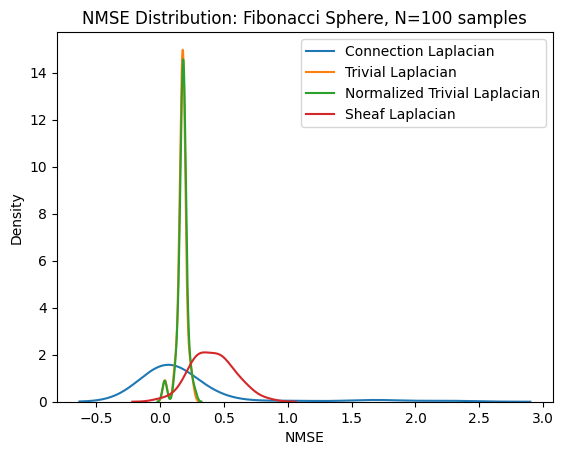

In [66]:
plot_nmse_distribution(sphere_nmse_results[100],'NMSE Distribution: Fibonacci Sphere, N=100 samples')

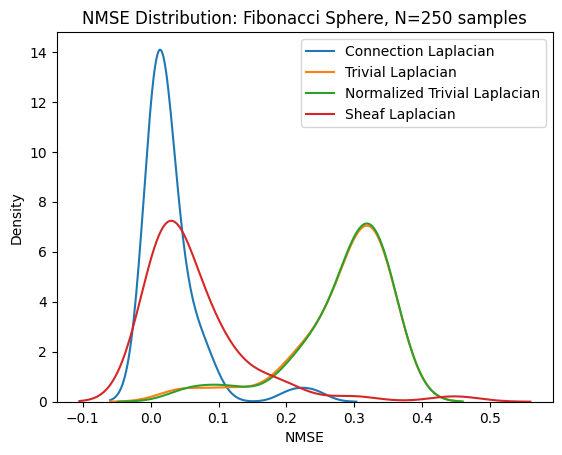

In [67]:
plot_nmse_distribution(sphere_nmse_results[250],'NMSE Distribution: Fibonacci Sphere, N=250 samples')

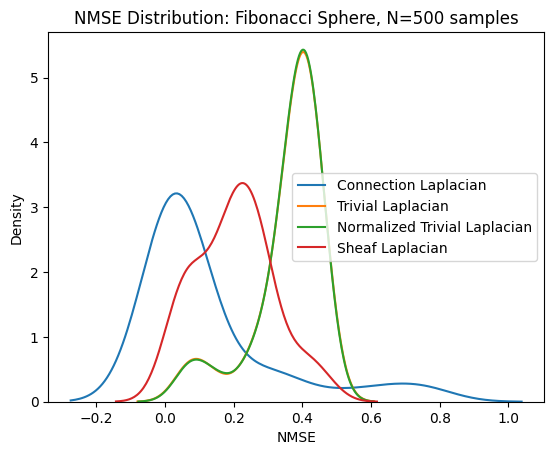

In [68]:
plot_nmse_distribution(sphere_nmse_results[500],'NMSE Distribution: Fibonacci Sphere, N=500 samples')

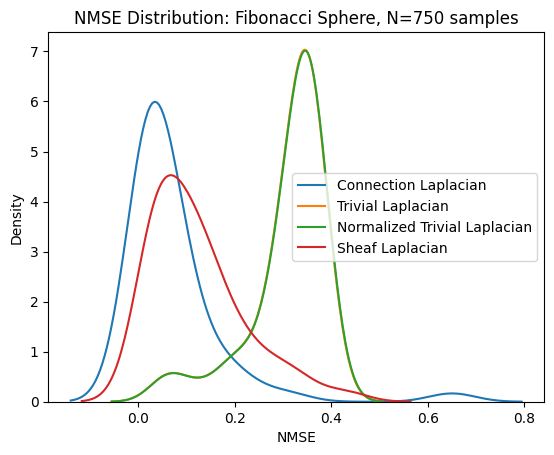

In [69]:
plot_nmse_distribution(sphere_nmse_results[750],'NMSE Distribution: Fibonacci Sphere, N=750 samples')

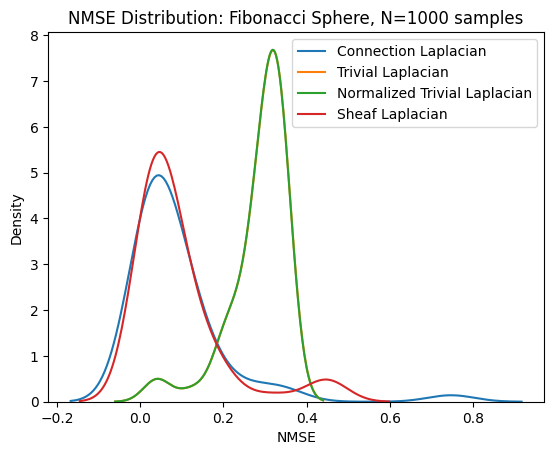

In [70]:
plot_nmse_distribution(sphere_nmse_results[1000],'NMSE Distribution: Fibonacci Sphere, N=1000 samples')

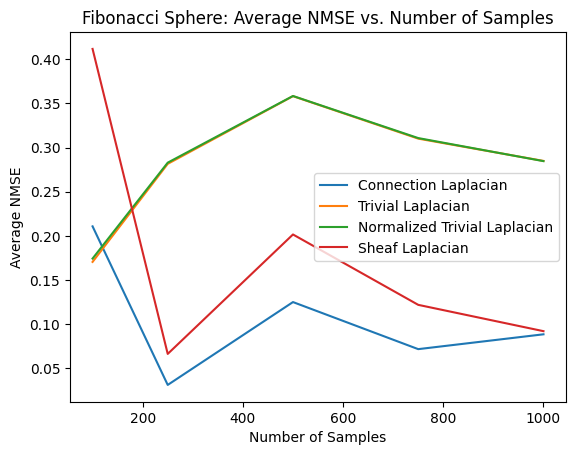

In [71]:
# Compute average NMSEs
sphere_avg_nmse_conn = []
sphere_avg_nmse_trivial = []
sphere_avg_nmse_trivial_norm = []
sphere_avg_nmse_sheaf = []

for N in N_:
    sphere_avg_nmse_conn.append(np.mean(sphere_nmse_results[N]['Connection']))
    sphere_avg_nmse_trivial.append(np.mean(sphere_nmse_results[N]['Trivial']))
    sphere_avg_nmse_trivial_norm.append(np.mean(sphere_nmse_results[N]['Trivial Normalized']))
    sphere_avg_nmse_sheaf.append(np.mean(sphere_nmse_results[N]['Sheaf']))

# Plot average NMSEs vs. number of samples
plt.plot(N_, sphere_avg_nmse_conn, label='Connection Laplacian')
plt.plot(N_, sphere_avg_nmse_trivial, label='Trivial Laplacian')
plt.plot(N_, sphere_avg_nmse_trivial_norm, label='Normalized Trivial Laplacian')
plt.plot(N_, sphere_avg_nmse_sheaf, label='Sheaf Laplacian')
plt.xlabel('Number of Samples')
plt.ylabel('Average NMSE')
plt.title('Fibonacci Sphere: Average NMSE vs. Number of Samples')
plt.legend()
plt.show()

# Weather Dataset

### Load the Dataset

A csv file is loaded, containing Swiss weather station coordinates and heights. The stations will be the nodes in the graph built by the VDM class.

In [2]:
stations = pd.read_csv('stations_ds.csv')
display(stations)

,nat_abbr,latitude,longitude,station_height
0,ABE,47.057969,7.285350,444.00
1,ABO,46.491703,7.560703,1321.38
2,AEG,47.133636,8.608206,724.43
3,AFI,47.604669,8.670289,360.00
4,AGATT,47.265233,8.050519,475.00
...,...,...,...,...
297,WYN,47.255025,7.787475,421.99
298,ZER,46.029272,7.752433,1638.35
299,ZEV,46.578797,9.118797,1738.00
300,ZWE,46.550511,7.384917,936.00


In [3]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nat_abbr        302 non-null    object 
 1   latitude        302 non-null    float64
 2   longitude       302 non-null    float64
 3   station_height  302 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.6+ KB


In [4]:
# Turn columns 1,2,3 (latitude, longitude, station_height) to a numpy array
station_geodetic = stations.iloc[:,1:4].to_numpy()
# Turn the coordinates from geodetic to R^3 points
x, y, z = geodetic_to_ecef(
    station_geodetic[:, 0],
    station_geodetic[:, 1],
    station_geodetic[:, 2]
)
station_points = np.column_stack((x, y, z))  # shape (N, 3)
station_points[:10]

array([[0.67575819, 0.08639101, 0.73204334],
       [0.68247416, 0.09058512, 0.72527468],
       [0.6726272 , 0.10182383, 0.7329424 ],
       [0.66653709, 0.10164081, 0.73851029],
       [0.67191781, 0.09503612, 0.73450296],
       [0.6698307 , 0.09771763, 0.73605577],
       [0.67498515, 0.09174883, 0.73210464],
       [0.68550921, 0.08325283, 0.72328838],
       [0.68029226, 0.10285349, 0.72568836],
       [0.66769497, 0.11241116, 0.73589888]])

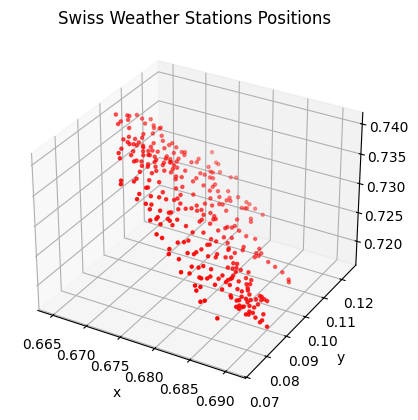

In [5]:
# Plot the cube
fig = plt.figure()  
ax = fig.add_subplot(projection='3d')
ax.scatter(station_points[:,0], station_points[:,1], station_points[:,2], marker='o', s=5, c='red')
plt.title('Swiss Weather Stations Positions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Find some distance statistics to choose good hyperparameters for the VDM class
def compute_distances(x):
    distances = []
    for i in range(x.shape[0]):
        for j in range(i+1, x.shape[0]):
            dist = np.linalg.norm(x[i] - x[j])
            distances.append(dist)
    return distances

distances = compute_distances(station_points)
print(f"Median distance between two stations: {np.median(distances)}")
print(f"Min and max distances: {np.min(distances)}, {np.max(distances)}")
print("First ten distances:")
print(sorted(distances, reverse=True)[:10])

Median distance between two stations: 0.01761227600907149
Min and max distances: 0.00037039650947565583, 0.05318045111323205
First ten distances:
[np.float64(0.05318045111323205), np.float64(0.05287267455556982), np.float64(0.052071312343405105), np.float64(0.05204996461640956), np.float64(0.05143259099883185), np.float64(0.050794923114699214), np.float64(0.05078056824714675), np.float64(0.05060660727475896), np.float64(0.050562648945038736), np.float64(0.05055124190410377)]


### Build the Graph

In [63]:
x = station_points  # point cloud
eps = 0.0003 # epsilon for the graph
eps_pca = 0.0002 # epsilon for the local PCA
k = 15 # number of neighbors in knn
gamma = 0.997 # information variability threshold in dimension estimation with singular values
vdm = VDM(x, eps, eps_pca, k, gamma)
G = vdm.make_graph()
print(f"Estimated dimension of the manifold: {vdm.estimate_dim()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph density: {G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1))}")

Estimated dimension of the manifold: 2
Number of edges: 22196
Graph density: 0.244175045653561


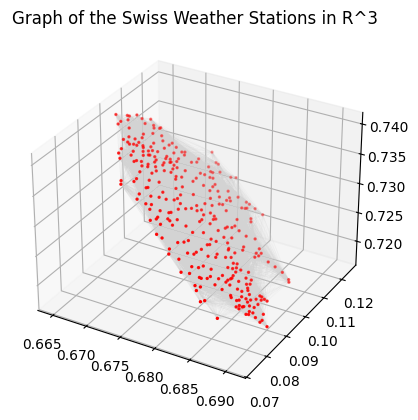

In [64]:
# Plot the graph
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='red')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='lightgrey', linewidth=0.1, alpha=0.5)
plt.title('Graph of the Swiss Weather Stations in R^3')
plt.show()

### Build the Laplacians

##### Connection Laplacian

In [8]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L_con = vdm.connection_laplacian() # approximation of the connection laplacian

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(L_con)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
# Suppress imaginary part if below 1e-15
for i in range(len(eigvals)):
    if np.abs(eigvals[i].imag) < 1e-15:
        eigvals[i] = eigvals[i].real
# If all values are real now, change data type from complex to float
if np.all(np.isreal(eigvals)):
    eigvals = eigvals.astype(np.float64)
print("Complex parts were suppressed because they were all below a 1e-15 tolerance. Data type changed to float64.")
print(f"Min eigenvalue: {eigvals[0]}, Max eigenvalue: {eigvals[-1]}")

Complex parts were suppressed because they were all below a 1e-15 tolerance. Data type changed to float64.
Min eigenvalue: -1.4941219944218032, Max eigenvalue: -0.25608233336434905


##### Trivial Bundle

In [ ]:
# Graph Laplacian
W = vdm.get_weight_matrix() # Weight matrix
d = vdm.get_degree_vector() # degree vector
d_sqrt = np.sqrt(d)
L_trivial = np.diag(d) - W # Graph Laplacian
L_trivial_norm = np.diag(1./d_sqrt) @ L_trivial @ np.diag(d_sqrt) # Normalized Laplacian

### Load Signals

In [108]:
# Load the signals (wind data)
wind_data_uv = np.load('wind_data_uv.npy')
wind_data_uv

array([[-0.9986295 , -0.33456534, -0.93358046, ...,  0.39999998,
         0.9801073 ,  0.52484727],
       [-0.05233597,  0.37157238,  0.35836792, ...,  0.69282037,
        -0.4993893 ,  0.60376763],
       [-0.70139384, -0.68404025, -0.70331603, ...,  1.4571847 ,
         1.0790098 , -0.03838944],
       ...,
       [-2.9870312 , -3.11127   , -3.5460484 , ..., -0.5846221 ,
        -0.48480958, -0.9563047 ],
       [ 0.76604456,  0.7269508 ,  0.7551845 , ...,  0.9439806 ,
         0.860083  ,  1.2362019 ],
       [ 0.6427875 ,  1.0777488 ,  0.9325752 , ...,  1.165719  ,
         2.2405932 ,  3.0597064 ]], shape=(302, 5616), dtype=float32)

In [119]:
u = wind_data_uv[::2,:] # zonal (east–west) wind component
v = wind_data_uv[1::2,:] # meridional (north–south) wind component
# Take the first signal
uv_signal = np.column_stack((u[:,0],v[:,0]))
uv_signal.shape

(151, 2)

In [120]:
uv_signal.shape

(151, 2)

In [123]:
O = vdm.make_orthonormal_bases()
len(O)

302

In [ ]:
# Project the signal point-wise on the tangent space of the graph
O = vdm.make_orthonormal_bases()
# ...